# Object Detection — HOG

## HOG 的全名是 Histograms of Oriented Gradients，是一種特徵提取的技術，透過區塊中 Gradient 方向來分別統計累積的 Gradient 強度，並以此作為該區塊的特徵。

## Step 1 : Input Image 

(1280, 1920, 3)

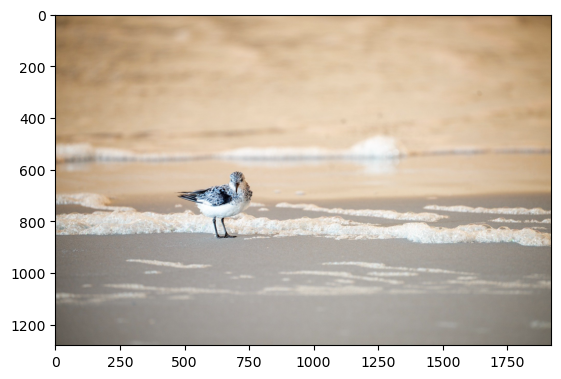

In [152]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("./OpenCV_3.4.6 examples/bird.jpg")

# img is a np.array
# 像素大小 = (1280, 1920, 3)
plt.imshow(img)
# plt.xticks([])
# plt.yticks([])
img.shape

## step 2 : ROI

## region of Interest，直接看整張圖雜訊太多

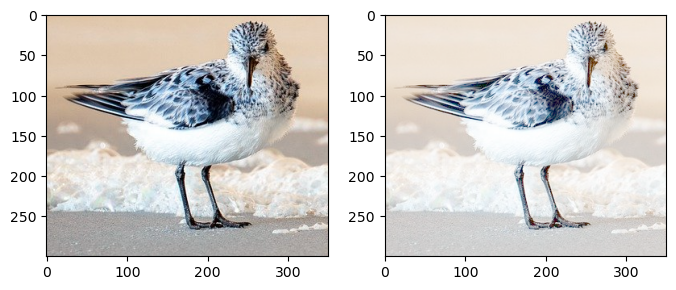

In [153]:
fig , ax =plt.subplots(1,2,figsize=(8,6))


# 設定ROI的左上角和右下角座標
# 看 ticks 找範圍
x, y, w, h = 450, 600, 350, 300  # 這裡示範的ROI左上角為(450, 600)

# 從原影像中切出ROI
roi = img[y:y+h, x:x+w]

# 顯示ROI
ax[0].imshow(roi)


# 對ROI進行Gamma矯正
gamma = 2.2
invGamma = 1.0 / gamma
table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
roi_gamma = cv2.LUT(roi, table)
ax[1].imshow(roi_gamma)

### 在這個範例中，我們先從原始影像中切出 ROI，然後對 ROI 進行 Gamma 矯正。在進行 Gamma 矯正之前，我們需要先設定 Gamma 值和反Gamma值，然後使用 NumPy 库中的函数創建一個 LUT（Look-Up Table），將每個像素的灰度值映射到經過 Gamma 矯正後的值。最後，我們使用 OpenCV 库中的 cv2.LUT() 函數將 ROI 映射到 Gamma 矯正後的值。您可以更改範例代碼中的 Gamma 值，以獲得更好的效果。

## step 3 : gradient 計算，如果這個像素屬於邊緣，那他的左一個與右一個應該會有色差，才能看出是邊緣。

[]

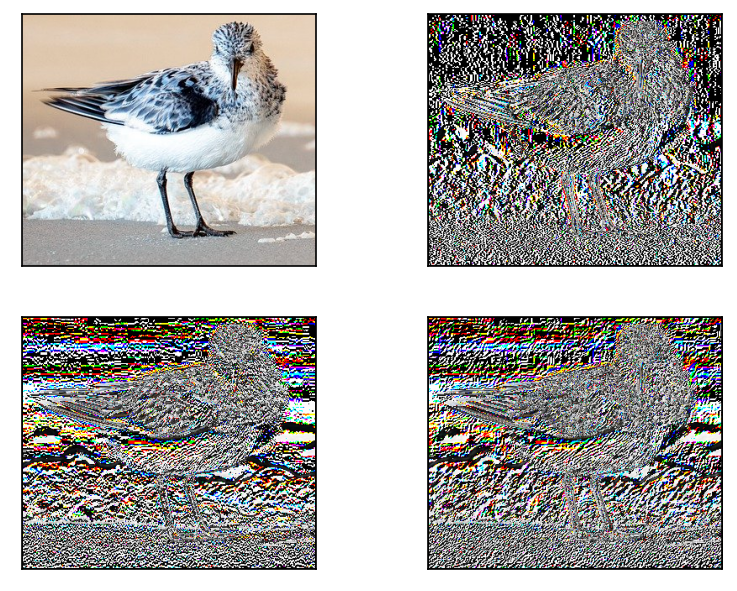

In [154]:
import cv2
import numpy as np

# 讀取圖像

fig , ax =plt.subplots(2,2,dpi=150)

# 複製圖像
grad_x = np.zeros_like(roi)
grad_y = np.zeros_like(roi)
grad_x_y = np.zeros_like(roi)

# 計算x和y方向的梯度
for i in range(1, roi.shape[0] - 1):
    for j in range(1, roi.shape[1] - 1):
        grad_x[i, j] = roi[i, j + 1] - roi[i, j - 1]
        grad_y[i, j] = roi[i + 1, j] - roi[i - 1, j]
        grad_x_y[i,j] = abs(grad_x[i,j]) + abs(grad_y[i,j]) 

# 顯示圖像和梯度
ax[0,0].imshow(roi)
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])

ax[0,1].imshow(grad_x)
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])

ax[1,0].imshow(grad_y)
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])

ax[1,1].imshow(grad_x_y)
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])

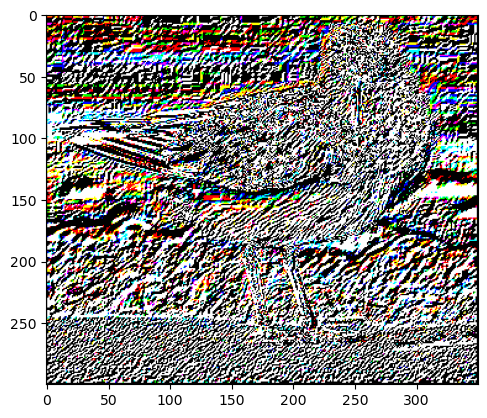

In [24]:
# 設定閥值，將邊緣二值化
threshold = 127
grad_x_y[grad_x_y < threshold] = 0
grad_x_y[grad_x_y >= threshold] = 255
grad_x_y.shape
plt.imshow(grad_x_y,cmap="bone")

In [23]:
# 計算梯度角度和大小
theta = np.arctan2(grad_y, grad_x)
# mag = np.sqrt(np.power(sobely, 2) + np.power(sobelx, 2))

# 將角度從 -pi~pi 轉換成 0~180
theta = np.rad2deg(theta) 

# 分成 9 個方向，分別為 0~20, 20~40, ..., 160~180
bins = np.int32(theta / 20)

# 將梯度大小填入對應的方向
hist = np.zeros(9)
for i in range(bins.shape[0]):
    for j in range(bins.shape[1]):
        hist[bins[i, j]] += grad_x_y[i, j]
        
np.unique(theta)

array([ 0.    ,  0.2247,  0.2256, ..., 89.7   , 89.75  , 90.    ],
      dtype=float16)

In [78]:
np.histogram(hist)

(array([5, 1, 0, 0, 0, 0, 0, 2, 0, 1], dtype=int64),
 array([      0.        ,  932389.54763528, 1864779.09527056,
        2797168.64290584, 3729558.19054112, 4661947.73817641,
        5594337.28581169, 6526726.83344697, 7459116.38108225,
        8391505.92871753, 9323895.47635281]))

In [12]:
# 計算梯度角度和大小
grad_x = np.float32(grad_x)
grad_y = np.float32(grad_y)
mag, ang = cv2.cartToPolar(grad_x, grad_y)
# bins = np.int32((ang * 180 / np.pi + 180) / 20)
# np.unique(bins)
# ang

<BarContainer object of 9 artists>

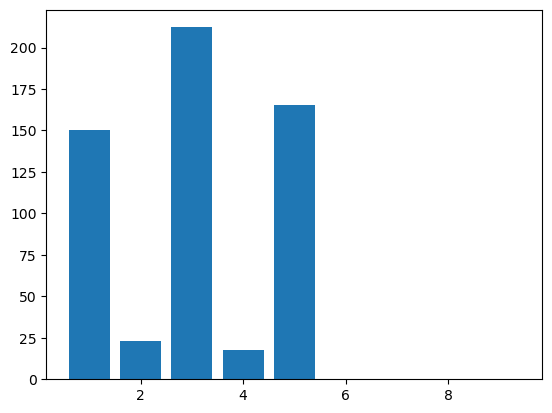

In [11]:
# 設定 bin 的數量
bins = 9
grad_x = np.float32(grad_x)
grad_y = np.float32(grad_y)

# 計算每個 pixel 的梯度方向和強度
magnitude, angle = cv2.cartToPolar(grad_x, grad_y, angleInDegrees=True)

# 將角度轉換為 0-180 的範圍
angle = angle % 180

# 計算每個像素屬於哪個 bin
bin_idx = np.int32(bins * angle / 180.0)

# 計算每個 bin 的強度總和
hist, _ = np.histogram(bin_idx, bins=bins, range=(0, bins), weights=magnitude)

# 將特徵向量進行歸一化
hist = hist / (roi.shape[0]*roi.shape[1])

# 印出特徵向量
plt.bar(np.arange(1,10,1),hist)


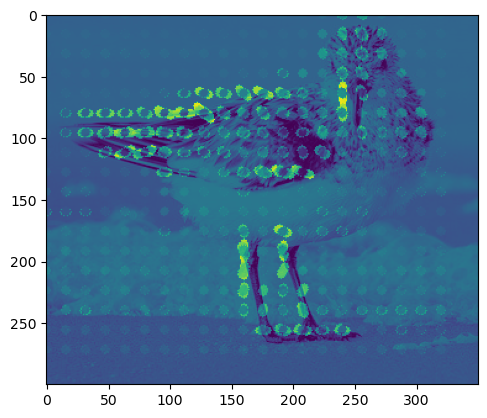

In [177]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt


class Hog_descriptor():
    def __init__(self, img, cell_size=16, bin_size=8):
        #圖片讀取跟 processing
        self.img = img
        self.img = np.sqrt(img / float(np.max(img)))
        self.img = self.img * 255
        self.cell_size = cell_size
        self.bin_size = bin_size
        self.angle_unit = 360 / self.bin_size
        assert type(self.bin_size) == int, "bin_size should be integer,"
        assert type(self.cell_size) == int, "cell_size should be integer,"
        #assert type(self.angle_unit) == int, "bin_size should be divisible by 360"

    def extract(self):
        height, width = self.img.shape
        gradient_magnitude, gradient_angle = self.global_gradient()
        gradient_magnitude = abs(gradient_magnitude)
        cell_gradient_vector = np.zeros((int(height / self.cell_size), int(width / self.cell_size), self.bin_size))
        for i in range(cell_gradient_vector.shape[0]):
            for j in range(cell_gradient_vector.shape[1]):
                cell_magnitude = gradient_magnitude[i * self.cell_size:(i + 1) * self.cell_size,
                                 j * self.cell_size:(j + 1) * self.cell_size]
                cell_angle = gradient_angle[i * self.cell_size:(i + 1) * self.cell_size,
                             j * self.cell_size:(j + 1) * self.cell_size]
                cell_gradient_vector[i][j] = self.cell_gradient(cell_magnitude, cell_angle)

        hog_image = self.render_gradient(np.zeros([height, width]), cell_gradient_vector)
        hog_vector = []
        for i in range(cell_gradient_vector.shape[0] - 1):
            for j in range(cell_gradient_vector.shape[1] - 1):
                block_vector = []
                block_vector.extend(cell_gradient_vector[i][j])
                block_vector.extend(cell_gradient_vector[i][j + 1])
                block_vector.extend(cell_gradient_vector[i + 1][j])
                block_vector.extend(cell_gradient_vector[i + 1][j + 1])
                mag = lambda vector: math.sqrt(sum(i ** 2 for i in vector))
                magnitude = mag(block_vector)
                if magnitude != 0:
                    normalize = lambda block_vector, magnitude: [element / magnitude for element in block_vector]
                    block_vector = normalize(block_vector, magnitude)
                hog_vector.append(block_vector)
        return hog_vector, hog_image

    def global_gradient(self):
        gradient_values_x = cv2.Sobel(self.img, cv2.CV_64F, 1, 0, ksize=5)
        gradient_values_y = cv2.Sobel(self.img, cv2.CV_64F, 0, 1, ksize=5)
        gradient_magnitude = cv2.addWeighted(gradient_values_x, 0.5, gradient_values_y, 0.5, 0)
        gradient_angle = cv2.phase(gradient_values_x, gradient_values_y, angleInDegrees=True)
        return gradient_magnitude, gradient_angle

    def cell_gradient(self, cell_magnitude, cell_angle):
        orientation_centers = [0] * self.bin_size
        for i in range(cell_magnitude.shape[0]):
            for j in range(cell_magnitude.shape[1]):
                gradient_strength = cell_magnitude[i][j]
                gradient_angle = cell_angle[i][j]
                min_angle, max_angle, mod = self.get_closest_bins(gradient_angle)
                orientation_centers[min_angle] += (gradient_strength * (1 - (mod / self.angle_unit)))
                orientation_centers[max_angle] += (gradient_strength * (mod / self.angle_unit))
        return orientation_centers

    def get_closest_bins(self, gradient_angle):
        idx = int(gradient_angle / self.angle_unit)
        mod = gradient_angle % self.angle_unit
        if idx == self.bin_size:
            return idx - 1, (idx) % self.bin_size, mod
        return idx, (idx + 1) % self.bin_size, mod

    def render_gradient(self, image, cell_gradient):
        cell_width = self.cell_size / 2
        max_mag = np.array(cell_gradient).max()
        transparent_image = np.zeros_like(image, dtype=np.uint8)  # 建立一個透明的黑色畫布
        for x in range(cell_gradient.shape[0]):
            for y in range(cell_gradient.shape[1]):
                cell_grad = cell_gradient[x][y]
                cell_grad /= max_mag
                angle = 0
                angle_gap = self.angle_unit
                for magnitude in cell_grad:
                    angle_radian = math.radians(angle)
                    x1 = int(x * self.cell_size + magnitude * cell_width * math.cos(angle_radian))
                    y1 = int(y * self.cell_size + magnitude * cell_width * math.sin(angle_radian))
                    x2 = int(x * self.cell_size - magnitude * cell_width * math.cos(angle_radian))
                    y2 = int(y * self.cell_size - magnitude * cell_width * math.sin(angle_radian))
                    color = int(255 * math.sqrt(magnitude))
                    if color > 0:
                        cv2.line(transparent_image, (y1, x1), (y2, x2), (color, color, color, 255), thickness=5)
                    angle += angle_gap
        return transparent_image
# img = cv2.imread("./OpenCV_3.4.6 examples/bird.jpg")

img = roi.mean(axis=2)
hog = Hog_descriptor(img, cell_size=16, bin_size=16)
vector, image = hog.extract()




roi_1 = np.float32(img)
image = np.float32(image)

result = cv2.addWeighted(roi_1, 0.5, image, 0.8, 0)

plt.imshow(result)
plt.show()

(10880,)

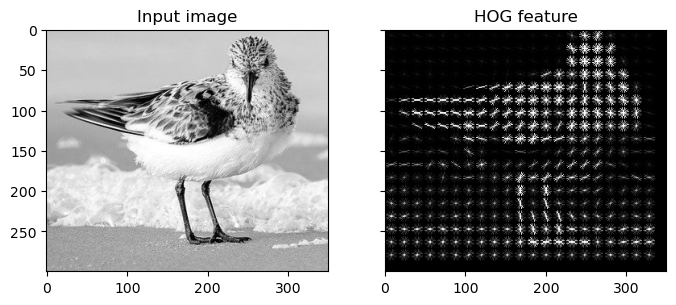

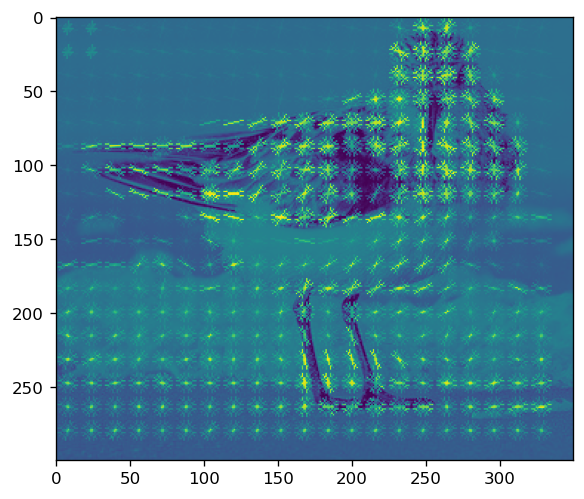

In [190]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import data, exposure

# 讀取範例圖片
# img = cv2.imread("./OpenCV_3.4.6 examples/shark_1.png",  cv2.IMREAD_GRAYSCALE)

# 設定 HOG 參數
orientations = 8
pixels_per_cell = (16, 16)
cells_per_block = (2, 2)

# 計算 HOG 特徵
fd, hog_image = hog(img , orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, visualize=True)

# 將 HOG 特徵圖像進行對比度增強
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

# 顯示 HOG 特徵圖像和原圖
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax1.imshow(roi_1 , cmap=plt.cm.gray)
ax1.set_title('Input image')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('HOG feature')

# 繪製箭頭
from skimage.draw import line_aa

for i in range(cells_per_block[0]):
    for j in range(cells_per_block[1]):
        cx = (i + 0.5) * pixels_per_cell[0]
        cy = (j + 0.5) * pixels_per_cell[1]
        for o in range(orientations):
            angle = o * (180 // orientations)
            hog_val = fd[o]
            dx = hog_val * pixels_per_cell[0] * np.cos(np.deg2rad(angle))
            dy = hog_val * pixels_per_cell[1] * np.sin(np.deg2rad(angle))
            rr, cc, val = line_aa(int(cy - dy), int(cx + dx), int(cy + dy), int(cx - dx))
            hog_image_rescaled[rr, cc] = np.maximum(hog_image_rescaled[rr, cc], val * hog_val )

            
            
img = roi_1
img = np.float32(img)
hog_image_rescaled    = np.float32(hog_image_rescaled)       
# 合併原圖與 HOG 特徵圖像
result = cv2.addWeighted(img,0.8, hog_image_rescaled *255,1, 0)
# 顯示帶箭頭的 HOG 特徵圖像
fig, ax = plt.subplots(dpi=120)
ax.imshow(result)
# ax.set_title('HOG feature with arrows')
# ax.set_xticks([])
# ax.set_yticks([])
# cv2.imwrite("result.png", result, [cv2.IMWRITE_PNG_COMPRESSION, 0])

# plt.show()
fd.shape

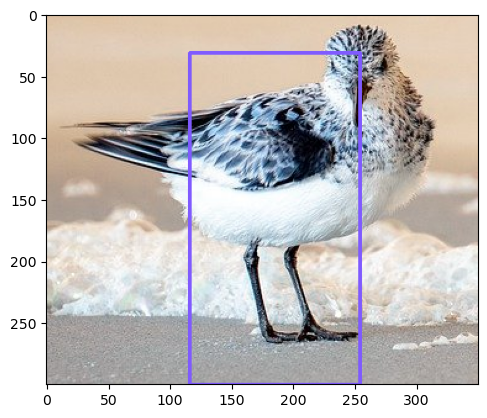

In [150]:
image_copy =roi.copy()

# Initialize the Histogram of Oriented Gradients descriptor
hog = cv2.HOGDescriptor()

# Set SVM detector and load the built-in pedestrian detector
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

# Set the parameter of descriptor and return the detection results
(rects, weights) = hog.detectMultiScale(roi, winStride=(4,4), padding=(8,8),
                                        scale=1.05)

# Loop over every bounding box and draw a rectangle around all pedestrians
for (x, y, w, h) in rects:
    cv2.rectangle(image_copy, (x,y), (x+w,y+h), (127,90,255), 2)
    
# Show the final result
plt.imshow(image_copy)
# cv2.imshow("After NMS", image)

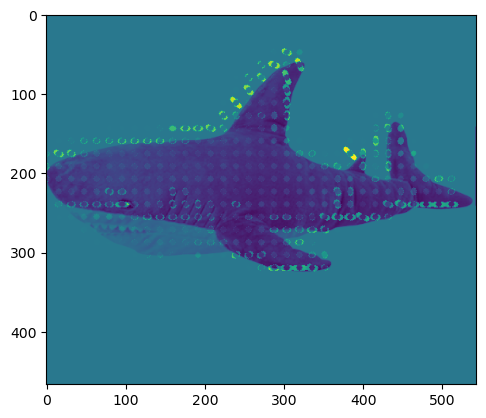

In [121]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt


class Hog_descriptor():
    def __init__(self, img, cell_size=16, bin_size=8):
        #圖片讀取跟 processing
        self.img = img
        self.img = np.sqrt(img / float(np.max(img)))
        self.img = self.img * 255
        self.cell_size = cell_size
        self.bin_size = bin_size
        self.angle_unit = 360 / self.bin_size
        assert type(self.bin_size) == int, "bin_size should be integer,"
        assert type(self.cell_size) == int, "cell_size should be integer,"
        #assert type(self.angle_unit) == int, "bin_size should be divisible by 360"

    def extract(self):
        height, width = self.img.shape
        gradient_magnitude, gradient_angle = self.global_gradient()
        gradient_magnitude = abs(gradient_magnitude)
        cell_gradient_vector = np.zeros((int(height / self.cell_size), int(width / self.cell_size), self.bin_size))
        for i in range(cell_gradient_vector.shape[0]):
            for j in range(cell_gradient_vector.shape[1]):
                cell_magnitude = gradient_magnitude[i * self.cell_size:(i + 1) * self.cell_size,
                                 j * self.cell_size:(j + 1) * self.cell_size]
                cell_angle = gradient_angle[i * self.cell_size:(i + 1) * self.cell_size,
                             j * self.cell_size:(j + 1) * self.cell_size]
                cell_gradient_vector[i][j] = self.cell_gradient(cell_magnitude, cell_angle)

        hog_image = self.render_gradient(np.zeros([height, width]), cell_gradient_vector)
        hog_vector = []
        for i in range(cell_gradient_vector.shape[0] - 1):
            for j in range(cell_gradient_vector.shape[1] - 1):
                block_vector = []
                block_vector.extend(cell_gradient_vector[i][j])
                block_vector.extend(cell_gradient_vector[i][j + 1])
                block_vector.extend(cell_gradient_vector[i + 1][j])
                block_vector.extend(cell_gradient_vector[i + 1][j + 1])
                mag = lambda vector: math.sqrt(sum(i ** 2 for i in vector))
                magnitude = mag(block_vector)
                if magnitude != 0:
                    normalize = lambda block_vector, magnitude: [element / magnitude for element in block_vector]
                    block_vector = normalize(block_vector, magnitude)
                hog_vector.append(block_vector)
        return hog_vector, hog_image

    def global_gradient(self):
        gradient_values_x = cv2.Sobel(self.img, cv2.CV_64F, 1, 0, ksize=5)
        gradient_values_y = cv2.Sobel(self.img, cv2.CV_64F, 0, 1, ksize=5)
        gradient_magnitude = cv2.addWeighted(gradient_values_x, 0.5, gradient_values_y, 0.5, 0)
        gradient_angle = cv2.phase(gradient_values_x, gradient_values_y, angleInDegrees=True)
        return gradient_magnitude, gradient_angle

    def cell_gradient(self, cell_magnitude, cell_angle):
        orientation_centers = [0] * self.bin_size
        for i in range(cell_magnitude.shape[0]):
            for j in range(cell_magnitude.shape[1]):
                gradient_strength = cell_magnitude[i][j]
                gradient_angle = cell_angle[i][j]
                min_angle, max_angle, mod = self.get_closest_bins(gradient_angle)
                orientation_centers[min_angle] += (gradient_strength * (1 - (mod / self.angle_unit)))
                orientation_centers[max_angle] += (gradient_strength * (mod / self.angle_unit))
        return orientation_centers

    def get_closest_bins(self, gradient_angle):
        idx = int(gradient_angle / self.angle_unit)
        mod = gradient_angle % self.angle_unit
        if idx == self.bin_size:
            return idx - 1, (idx) % self.bin_size, mod
        return idx, (idx + 1) % self.bin_size, mod

    def render_gradient(self, image, cell_gradient):
        cell_width = self.cell_size / 2
        max_mag = np.array(cell_gradient).max()
        transparent_image = np.zeros_like(image, dtype=np.uint8)  # 建立一個透明的黑色畫布
        for x in range(cell_gradient.shape[0]):
            for y in range(cell_gradient.shape[1]):
                cell_grad = cell_gradient[x][y]
                cell_grad /= max_mag
                angle = 0
                angle_gap = self.angle_unit
                for magnitude in cell_grad:
                    angle_radian = math.radians(angle)
                    x1 = int(x * self.cell_size + magnitude * cell_width * math.cos(angle_radian))
                    y1 = int(y * self.cell_size + magnitude * cell_width * math.sin(angle_radian))
                    x2 = int(x * self.cell_size - magnitude * cell_width * math.cos(angle_radian))
                    y2 = int(y * self.cell_size - magnitude * cell_width * math.sin(angle_radian))
                    color = int(255 * math.sqrt(magnitude))
                    if color > 0:
                        cv2.line(transparent_image, (y1, x1), (y2, x2), (color, color, color, 255), thickness=5)
                    angle += angle_gap
        return transparent_image
# img = cv2.imread("./OpenCV_3.4.6 examples/bird.jpg")
img = cv2.imread("./OpenCV_3.4.6 examples/shark_1.png", cv2.IMREAD_GRAYSCALE)
# img = np.mean(img,axis=2)
hog = Hog_descriptor(img, cell_size=16, bin_size=16)
vector, image = hog.extract()

img = cv2.imread("./OpenCV_3.4.6 examples/shark_1.png",  cv2.IMREAD_GRAYSCALE)


img = np.float32(img)
image = np.float32(image)

result = cv2.addWeighted(img, 0.8, image, 1.2, 0)

plt.imshow(result)
plt.show()


In [92]:
cv2.imwrite("result.png", result, [cv2.IMWRITE_PNG_COMPRESSION, 0])
from PIL import Image
img = Image.open("result.png")
img = img.convert("RGBA")
datas = img.getdata()

new_data = []
for item in datas:
    if item[0] == 0 and item[1] == 0 and item[2] == 0:
        new_data.append((0, 0, 0, 0))
    else:
        new_data.append(item)

img.putdata(new_data)
img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
cv2.imshow("Result", img)
cv2.waitKey(0)

-1

(28672,)

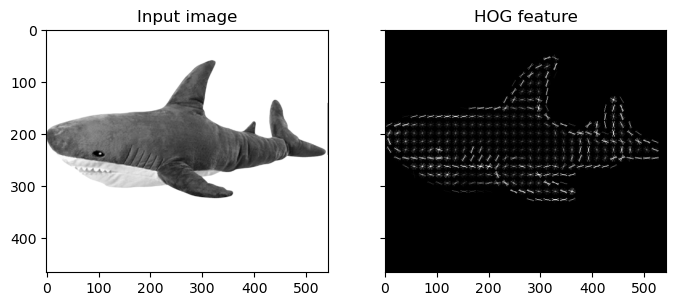

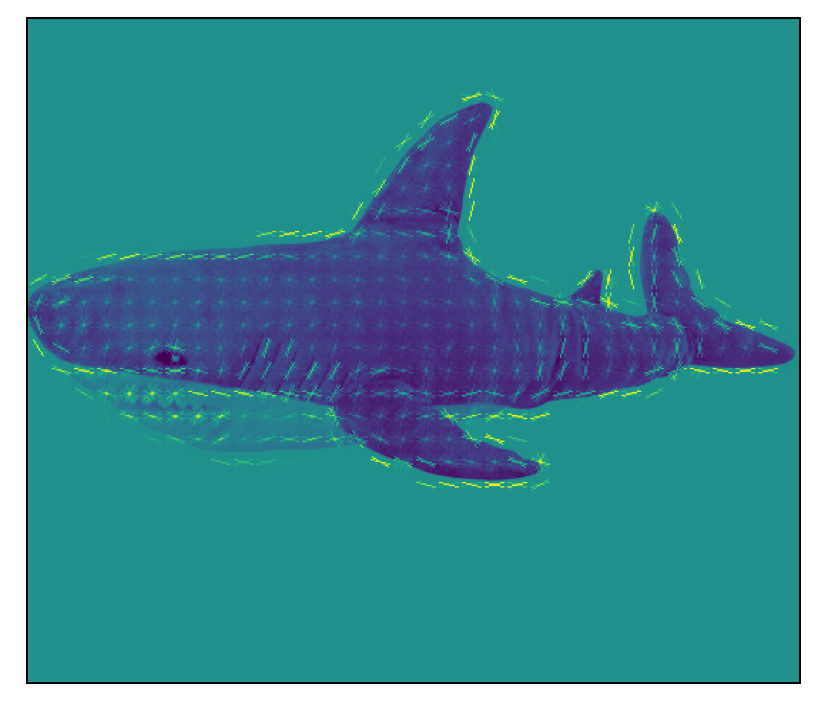

In [148]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import data, exposure

# 讀取範例圖片
img = cv2.imread("./OpenCV_3.4.6 examples/shark_1.png",  cv2.IMREAD_GRAYSCALE)

# 設定 HOG 參數
orientations = 8
pixels_per_cell = (16, 16)
cells_per_block = (2, 2)

# 計算 HOG 特徵
fd, hog_image = hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, visualize=True)

# 將 HOG 特徵圖像進行對比度增強
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

# 顯示 HOG 特徵圖像和原圖
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax1.imshow(img, cmap=plt.cm.gray)
ax1.set_title('Input image')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('HOG feature')

# 繪製箭頭
from skimage.draw import line_aa

for i in range(cells_per_block[0]):
    for j in range(cells_per_block[1]):
        cx = (i + 0.5) * pixels_per_cell[0]
        cy = (j + 0.5) * pixels_per_cell[1]
        for o in range(orientations):
            angle = o * (180 // orientations)
            hog_val = fd[ o]
            dx = hog_val * pixels_per_cell[0] * np.cos(np.deg2rad(angle))
            dy = hog_val * pixels_per_cell[1] * np.sin(np.deg2rad(angle))
            rr, cc, val = line_aa(int(cy - dy), int(cx + dx), int(cy + dy), int(cx - dx))
            hog_image_rescaled[rr, cc] = np.maximum(hog_image_rescaled[rr, cc], val * hog_val * 255)

            
            
img = cv2.imread("./OpenCV_3.4.6 examples/shark_1.png",  cv2.IMREAD_GRAYSCALE)

img = np.float32(img)
hog_image_rescaled    = np.float32(hog_image_rescaled)       
# 合併原圖與 HOG 特徵圖像
result = cv2.addWeighted(img, 0.5, hog_image_rescaled*255, 0.5, 0)
# 顯示帶箭頭的 HOG 特徵圖像
fig, ax = plt.subplots(dpi=180)
ax.imshow(result)
# ax.set_title('HOG feature with arrows')
ax.set_xticks([])
ax.set_yticks([])
cv2.imwrite("result.png", result, [cv2.IMWRITE_PNG_COMPRESSION, 0])

# plt.show()
fd.shape

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15240\1232502018.py:22: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img_1 = img_1.resize((192, 168),  resample=Image.ANTIALIAS)


[]

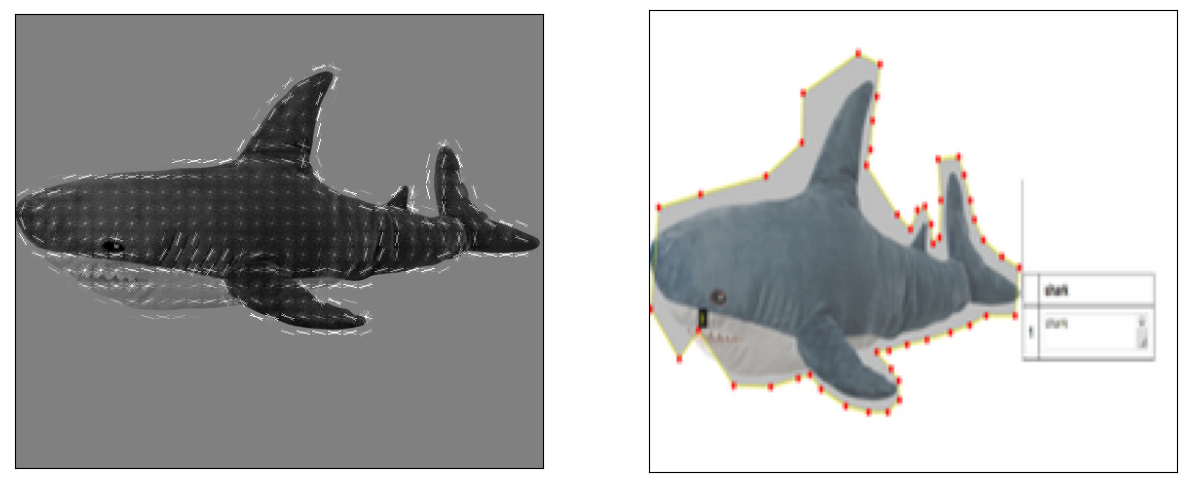

In [145]:
cv2.imwrite("result.png", result, [cv2.IMWRITE_PNG_COMPRESSION, 0])
from PIL import Image
img = Image.open("result.png")
img = img.convert("RGBA")
datas = img.getdata()

new_data = []
for item in datas:
    if item[0] == 0 and item[1] == 0 and item[2] == 0:
        new_data.append((0, 0, 0, 0))
    else:
        new_data.append(item)

img.putdata(new_data)
img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

fig , ax =plt.subplots(1,2,figsize=(15,10))
# img_1 = cv2.imread("./OpenCV_3.4.6 examples/shark_1_bounding.png")
img_1 = Image.open("./OpenCV_3.4.6 examples/shark_1_bounding.png")

    # 進行縮放，使用ANTIALIAS模式以改善縮放品質
img_1 = img_1.resize((192, 168),  resample=Image.ANTIALIAS)


ax[0].imshow(img,cmap="gist_rainbow_r")
ax[1].imshow(img_1)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])